In [1]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
import copy
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

/opt/conda/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
origin = pd.read_csv('horse.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train = train.replace('None', np.NaN)
test = test.replace('None', np.NaN)
origin = origin.replace('None', np.NaN)

# Combine both original and training data
train = pd.concat([train, origin], ignore_index=True)

In [3]:
def lesion_1_num(x):
    if x!=0:
        if len(str(x))==5 and int(str(x)[3:])!=10:
            return int(str(x)[:2])
        else:
            return int(str(x)[0])
    else:
        return 0
def lesion_2_num(x):
    if x!=0:
        return int(str(x)[1])
    else:
        return 0
def lesion_3_num(x):
    if x!=0:
        if len(str(x))==2:
            x=x*100
        elif len(str(x))==3:
            x=x*10
        if len(str(x))==5:
            return int(str(x)[3])
        else: 
            return int(str(x)[2])
    else:
        return 0
def lesion_4_num(x):
    if x!=0:
        if len(str(x))==2:
            x=x*100
        elif len(str(x))==3:
            x=x*10
        if len(str(x))==5 and int(str(x)[3:])!=10:
            return int(str(x)[4:])
        else:
            return int(str(x)[3:])
    else:
        return 0
lesion_1 = {
    1: 'Gastric',
    2: 'Small Intestine',
    3: 'Large Colon',
    4: 'Large Colon and Cecum',
    5: 'Cecum',
    6: 'Transverse Colon',
    7: 'Rectum/Descending Colon',
    8: 'Uterus',
    9: 'Bladder',
    11: 'All Intestinal Sites',
    0: 'N/A'
}

lesion_2 = {
    1: 'Simple',
    2: 'Strangulation',
    3: 'Inflammation',
    4: 'Other'
}

lesion_3 = {
    1: 'Mechanical',
    2: 'Paralytic',
    0: 'N/A'
}

lesion_4 = {
    1: 'Obturation',
    2: 'Intrinsic',
    3: 'Extrinsic',
    4: 'Adynamic',
    5: 'Volvulus/Torsion',
    6: 'Intussuption',
    7: 'Thromboembolic',
    8: 'Hernia',
    9: 'Lipoma/Splenic Incarceration',
    10: 'Displacement',
    0: 'N/A'
}

In [4]:
def clean_and_transform(df):
    df=df.drop(columns=['lesion_3'])
    # change 3 to more_3_sec
    df['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)
    # convert slight and moderate to mild pain category
    df['pain'].replace({'slight': 'mild_pain'}, inplace=True)
    df['pain'].replace({'moderate': 'mild_pain'}, inplace=True)
    # clean below 3 columns
    df['peristalsis'].replace({'distend_small': np.nan}, inplace=True)
    df['nasogastric_reflux'].replace({'slight': np.nan}, inplace=True)
    df['rectal_exam_feces'].replace({'serosanguious': np.nan}, inplace=True)
    
    df['hospital_number_freq'] = df['hospital_number'].apply(lambda x: df['hospital_number'].value_counts()[x])
    df['hospital_number'] = df['hospital_number'].astype(int)
    df['hospital_number_count'] = df['hospital_number'].map(df['hospital_number'].value_counts())

    #df['rectal_temp'] = abs(df['rectal_temp'] - 37.8)
    #df['pulse_resp'] = df['pulse']*df['respiratory_rate']
    #df['pulse'] = abs(df['pulse'] - 60)
    #df['protein'] = df['total_protein']/df['abdomo_protein']
    df['total_protein_cat'] = df['total_protein'] > 40
    
    """
    df['lesion_1'] = df['lesion_1'].astype('str')
    df['lesion1'] = df['lesion_1'].apply(lambda x: x+'0'*(4-len(x)) if len(x) <= 4 else x)
    df['lesion_site'] = df['lesion1'].apply(lambda x: x[:2] if len(x) == 5 and x[0] == '1' else x[0])
    df['lesion_type'] = df['lesion1'].apply(lambda x: x[2] if len(x) == 5 and x[0] == '1' else x[1])
    df['lesion_subtype'] = df['lesion1'].apply(lambda x: x[3] if len(x) == 5 and x[0] == '1' else x[2])
    df['lesion_code'] = df['lesion1'].apply(lambda x: x[-2:] if len(x) == 5 and x[0] != '1' else x[-1])
    df.lesion_type.replace({'7': '0'}, inplace=True)
    df = df.drop(['id', 'lesion1', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)
    """
    df['lesion_1_1']=df['lesion_1'].apply(lesion_1_num).replace(lesion_1)
    df['lesion_1_2']=df['lesion_1'].apply(lesion_2_num).replace(lesion_2)
    df['lesion_1_3']=df['lesion_1'].apply(lesion_3_num).replace(lesion_3)
    df['lesion_1_4']=df['lesion_1'].apply(lesion_4_num).replace(lesion_4)
    
    df['lesion_2_1']=df['lesion_2'].apply(lesion_1_num).replace(lesion_1)
    df['lesion_2_2']=df['lesion_2'].apply(lesion_2_num).replace(lesion_2)
    df['lesion_2_3']=df['lesion_2'].apply(lesion_3_num).replace(lesion_3)
    df['lesion_2_4']=df['lesion_2'].apply(lesion_4_num).replace(lesion_4)
    
    df['lesion_1_1_num'] = df['lesion_1'].apply(lesion_1_num)
    df['lesion_1_2_num'] = df['lesion_1'].apply(lesion_2_num)
    df['lesion_1_3_num'] = df['lesion_1'].apply(lesion_3_num)
    df['lesion_1_4_num'] = df['lesion_1'].apply(lesion_4_num)
    
    df['lesion_2_1_num'] = df['lesion_2'].apply(lesion_1_num)
    df['lesion_2_2_num'] = df['lesion_2'].apply(lesion_2_num)
    df['lesion_2_3_num'] = df['lesion_2'].apply(lesion_3_num)
    df['lesion_2_4_num'] = df['lesion_2'].apply(lesion_4_num)
    
    df['lesion_1_tot']=df['lesion_1_1_num']+df['lesion_1_2_num']+df['lesion_1_3_num']+df['lesion_1_4_num']
    df['lesion_2_tot']=df['lesion_2_1_num']+df['lesion_2_2_num']+df['lesion_2_3_num']+df['lesion_2_4_num']
    

    return df

In [5]:
train_df = clean_and_transform(train)
test_df = clean_and_transform(test)

# Crie um dicionário para manter o controle das contagens de hospital_number
hospital_number_counts = {}

# Função para atribuir a contagem incremental
def assign_incremental_count(hospital_number):
    if hospital_number in hospital_number_counts:
        hospital_number_counts[hospital_number] += 1
    else:
        hospital_number_counts[hospital_number] = 1
    return hospital_number_counts[hospital_number]

# Aplique a função para criar a coluna 'hospital_number_incremental_count' no DataFrame de treinamento
train_df['hospital_number_incremental_count'] = train_df['hospital_number'].map(assign_incremental_count)

# Aplique a função para criar a coluna 'hospital_number_incremental_count' no DataFrame de teste
test_df['hospital_number_incremental_count'] = test_df['hospital_number'].map(assign_incremental_count)
# Crie uma coluna booleana para sinalizar se é a primeira vez
train_df['is_first_hospital_number'] = train_df['hospital_number_incremental_count'] == 1
test_df['is_first_hospital_number'] = test_df['hospital_number_incremental_count'] == 1


test_df['lesion_2_1']=test_df['lesion_2_1'].replace({"Large_Colon_and_Cecum":"Large_Colon"})
test_df['lesion_2_2']=test_df['lesion_2_2'].replace({"Inflammation":"Other_2"})

train_df=train_df.drop(columns=['hospital_number'])
test_df=test_df.drop(columns=['hospital_number'])

In [6]:
def delete_missing_row(df):
    missing_values_per_row = df.isna().sum(axis=1)
    print(df.shape)
    threshold = 10
    df = df[missing_values_per_row <= threshold]
    print(df.shape)
    df = df.reset_index(drop=True)
    return df
train = delete_missing_row(train)
train_df = delete_missing_row(train_df)

(1534, 29)
(1494, 29)
(1534, 50)
(1494, 50)


In [7]:
# Replace categorical missing values with mode
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combined the data so that no category is missed and
    the category with least frequency can be dropped because of redunancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

for col in train_df.select_dtypes('number').columns:
    train_df, test_df = min_max_scaler(train_df, test_df, col)
train_df, test_df = OHE(train_df, test_df, train_df.drop('outcome', axis=1).select_dtypes('object').columns, 'outcome')

In [8]:
train_cop = train_df.copy().drop(['id'], axis=1)
test_cop = test_df.copy().drop(['id'],axis=1)

target_map={
    "lived":0,
    "died": 1,
    "euthanized":2
}     

def encode(y,target_map):
    '''
    To convert the outputs to numbers
    '''
    y=np.array(y)
    encoded_y=[target_map[f] for f in y]
    return encoded_y
def decode(y,target_map):
    '''To convert the predictions back to classes
    '''
    y=np.array(y)
    reverse_dict={v: k for k, v in target_map.items()}
    decoded_y=[reverse_dict[f] for f in y]
    return decoded_y

def better_features(train, test, target, cols, best_score):
    new_cols = []
    skf = KFold(n_splits=5, shuffle=True, random_state=42)  # Stratified k-fold object
    best_list=[]
    for i in tqdm(range(len(cols)), desc='Generating Columns'):
        col1 = cols[i]
        temp_df = pd.DataFrame()  # Temporary dataframe to store the generated columns
        temp_df_test = pd.DataFrame()  # Temporary dataframe for test data

        for j in range(i+1, len(cols)):
            col2 = cols[j]
            # Multiply
            temp_df[col1 + '*' + col2] = train[col1] * train[col2]
            temp_df_test[col1 + '*' + col2] = test[col1] * test[col2]

            # Divide (col1 / col2)
            temp_df[col1 + '/' + col2] = train[col1] / (train[col2] + 1e-5)
            temp_df_test[col1 + '/' + col2] = test[col1] / (test[col2] + 1e-5)

            # Divide (col2 / col1)
            temp_df[col2 + '/' + col1] = train[col2] / (train[col1] + 1e-5)
            temp_df_test[col2 + '/' + col1] = test[col2] / (test[col1] + 1e-5)

            # Subtract
            temp_df[col1 + '-' + col2] = train[col1] - train[col2]
            temp_df_test[col1 + '-' + col2] = test[col1] - test[col2]

            # Add
            temp_df[col1 + '+' + col2] = train[col1] + train[col2]
            temp_df_test[col1 + '+' + col2] = test[col1] + test[col2]

        SCORES = []
        for column in temp_df.columns:
            scores = []
            for train_index, val_index in skf.split(train, train[target]):
                X_train, X_val = temp_df[column].iloc[train_index].values.reshape(-1, 1), temp_df[column].iloc[val_index].values.reshape(-1, 1)
                y_train, y_val = train[target].iloc[train_index], train[target].iloc[val_index]
                model = SVC(gamma="auto", probability=True, random_state=42)
                model.fit(X_train,  encode(y_train, target_map))
                y_pred = model.predict(X_val)
                score = f1_score( encode(y_val, target_map), y_pred, average='micro')
                scores.append(score)
            mean_score = np.mean(scores)
            SCORES.append((column, mean_score))

        if SCORES:
            best_col, best_f1 = sorted(SCORES, key=lambda x: x[1],reverse=True)[0]
            corr_with_other_cols = train.drop([target] + new_cols, axis=1).corrwith(temp_df[best_col])
            if (corr_with_other_cols.abs().max() < 0.9 or best_f1 > best_score) and corr_with_other_cols.abs().max() !=1 :
                train[best_col] = temp_df[best_col]
                test[best_col] = temp_df_test[best_col]
                new_cols.append(best_col)
                print(f"Added column '{best_col}' with F1 Score: {best_f1:.4f} & Correlation {corr_with_other_cols.abs().max():.4f}")

    return train, test, new_cols

def apply_arithmetic_operations(train_df, test_df, expressions_list):
    for expression in expressions_list:
        if expression not in train_df.columns:
            # Split the expression based on operators (+, -, *, /)
            parts = expression.split('+') if '+' in expression else \
                    expression.split('-') if '-' in expression else \
                    expression.split('*') if '*' in expression else \
                    expression.split('/')

            # Get the DataFrame column names involved in the operation
            cols = [col for col in parts]

            # Perform the corresponding arithmetic operation based on the operator in the expression
            if cols[0] in train_df.columns and cols[1] in train_df.columns:
                if '+' in expression:
                    train_df[expression] = train_df[cols[0]] + train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] + test_df[cols[1]]
                elif '-' in expression:
                    train_df[expression] = train_df[cols[0]] - train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] - test_df[cols[1]]
                elif '*' in expression:
                    train_df[expression] = train_df[cols[0]] * train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] * test_df[cols[1]]
                elif '/' in expression:
                    train_df[expression] = train_df[cols[0]] / (train_df[cols[1]]+1e-5)
                    test_df[expression] = test_df[cols[0]] /( test_df[cols[1]]+1e-5)
    
    return train_df, test_df

new_cols = ['rectal_temp/pulse', 'total_protein/pulse', 'Strangulationlesion_1_2/respiratory_rate', 'nasogastric_reflux_ph/serosanguiousabdomo_appearance',
            'packed_cell_volume/lesion_1_3_num', 'total_protein/lesion_1_2_num', 'abdomo_protein/mild_painpain', 'lesion_1/normal_pinkmucous_membrane', 
            'lesion_1_1_num/Volvulus_Torsionlesion_1_4', 'serosanguiousabdomo_appearance/lesion_1_3_num', 'lesion_1_4_num/mild_painpain', 'lesion_1_tot/mild_painpain', 
            'serosanguiousabdomo_appearance/yessurgery', 'serosanguiousabdomo_appearance/coldtemp_of_extremities', 'serosanguiousabdomo_appearance/cooltemp_of_extremities', 
            'normaltemp_of_extremities+less_3_seccapillary_refill_time', 'normalperipheral_pulse+mild_painpain', 'reducedperipheral_pulse/mild_painpain',
            'serosanguiousabdomo_appearance/bright_redmucous_membrane', 'serosanguiousabdomo_appearance/dark_cyanoticmucous_membrane', 'serosanguiousabdomo_appearance/pale_cyanoticmucous_membrane', 
            'pale_pinkmucous_membrane-serosanguiousabdomo_appearance', 'less_3_seccapillary_refill_time/severe_painpain', 'serosanguiousabdomo_appearance/depressedpain', 'extreme_painpain+serosanguiousabdomo_appearance', 
            'yessurgical_lesion/mild_painpain', 'severe_painpain+serosanguiousabdomo_appearance', 'serosanguiousabdomo_appearance/absentperistalsis', 'serosanguiousabdomo_appearance/hypomotileperistalsis',
            'serosanguiousabdomo_appearance/moderateabdominal_distention', 'noneabdominal_distention-serosanguiousabdomo_appearance', 'slightabdominal_distention-serosanguiousabdomo_appearance',
            'serosanguiousabdomo_appearance/nonenasogastric_tube', 'serosanguiousabdomo_appearance/slightnasogastric_tube', 'serosanguiousabdomo_appearance/more_1_liternasogastric_reflux', 
            'serosanguiousabdomo_appearance/nonenasogastric_reflux', 'serosanguiousabdomo_appearance/absentrectal_exam_feces', 'serosanguiousabdomo_appearance/decreasedrectal_exam_feces', 'serosanguiousabdomo_appearance/distend_largeabdomen', 
            'serosanguiousabdomo_appearance/distend_smallabdomen', 'serosanguiousabdomo_appearance/Simplelesion_1_2', 'yessurgical_lesion*NA3lesion_1_3', 'Volvulus_Torsionlesion_1_4/yescp_data', 'Gastriclesion_1_1+Volvulus_Torsionlesion_1_4',
            'Strangulationlesion_1_2/Large_Colonlesion_1_1', 'Volvulus_Torsionlesion_1_4/Large_Colon_and_Cecumlesion_1_1', 'NA3lesion_1_3/NA_1lesion_1_1', 'Volvulus_Torsionlesion_1_4/Small_Intestinelesion_1_1', 
            'Volvulus_Torsionlesion_1_4/NA3lesion_1_3', 'Lipoma_Splenic_Incarcerationlesion_1_4+Volvulus_Torsionlesion_1_4', 'Large_Colonlesion_2_1+NA_1lesion_2_1']

new_cols_1 = ['rectal_temp/pulse', 'total_protein/pulse', 'Strangulationlesion_1_2/respiratory_rate', 'nasogastric_reflux_ph/serosanguiousabdomo_appearance',
            'packed_cell_volume/lesion_1_3_num', 'total_protein/lesion_1_2_num', 'abdomo_protein/mild_painpain', 'lesion_1/normal_pinkmucous_membrane', 
            'lesion_1_1_num/Volvulus_Torsionlesion_1_4', 'serosanguiousabdomo_appearance/lesion_1_3_num', 'lesion_1_4_num/mild_painpain', 'lesion_1_tot/mild_painpain',
             'normalperipheral_pulse+mild_painpain','reducedperipheral_pulse/mild_painpain','less_3_seccapillary_refill_time/severe_painpain',
             'extreme_painpain+serosanguiousabdomo_appearance','yessurgical_lesion/mild_painpain','severe_painpain+serosanguiousabdomo_appearance',
              'serosanguiousabdomo_appearance/Simplelesion_1_2', 'yessurgical_lesion*NA3lesion_1_3'
             ]
train_cop, test_cop = apply_arithmetic_operations(train_cop, test_cop, new_cols_1)
#train_cop, test_cop, new_cols = better_features(train_cop, test_cop, 'outcome', train_cop.select_dtypes('number').columns, 0.9)

train_df = pd.concat([train_cop,train_df['id']], axis=1)
test_df = pd.concat([test_cop, test_df['id']], axis=1)

In [9]:
numerical_features = list(train_df.select_dtypes('number').columns)
categorical_features = list(set(train_df.columns)-set(numerical_features)-set(['outcome'])-set(['id'])-set(['index']))

In [10]:
le = LabelEncoder()
oe = OrdinalEncoder()

oe_lst = ['abdominal_distention', 'rectal_exam_feces', 'nasogastric_tube', 'capillary_refill_time', 'mucous_membrane', 'peripheral_pulse', 'temp_of_extremities', 'age', 'abdomen', 'peristalsis','nasogastric_reflux']
custom_lst = ['lesion_1_1', 'lesion_1_2', 'lesion_1_3', 'lesion_1_4', 'lesion_2_1', 'lesion_2_2', 'lesion_2_3', 'lesion_2_4']
le_lst = list(set(categorical_features)-set(oe_lst)-set(custom_lst))

In [11]:
for col in oe_lst:
    train_df[col] = oe.fit_transform(train_df[col])
    test_df[col] = oe.transform(test_df[col])

"""
def freq_encode(train_data, columns):
    encoded_cols = []
    n_samples = train_data.shape[0]
    for col in columns:
        freqs_cat = train_data.groupby(col)[col].count() / n_samples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_cols.append(pd.DataFrame({'freq_'+ col:encoded_col_train}))
    return pd.concat(encoded_cols, axis=1)

train_freq_cols = freq_encode(train_df, oe_lst)
train_df = train_df.drop(oe_lst, axis=1)
train_df = pd.concat([train_df,train_freq_cols],axis=1)

test_freq_cols = freq_encode(test_df, oe_lst)
test_df = test_df.drop(oe_lst, axis=1)
test_df = pd.concat([test_df,test_freq_cols],axis=1)
"""

"""
train_df['outcome'] = train_df['outcome'].map(({'died': 0, 'lived': 1, 'euthanized': 2}))

def target_encode(train_data, test_data, target, columns, alpha=0.5):
    n_rows = train_data.shape[0]
    global_mean = train_data[target].mean()
    encoded_cols_train = []
    encoded_cols_test = []
    
    for col in columns:
        target_mean = train_data.groupby(col)[target].mean()
        smoothing = (target_mean * n_rows + global_mean * alpha) / (n_rows + alpha)
        
        encoded_col_train = train_data[col].map(smoothing)
        encoded_col_test = test_data[col].map(smoothing)
        
        encoded_cols_train.append(pd.DataFrame({col:encoded_col_train}))
        encoded_cols_test.append(pd.DataFrame({col:encoded_col_test}))
        
    return pd.concat(encoded_cols_train, axis=1), pd.concat(encoded_cols_test, axis=1)

tar_train, tar_test=target_encode(train_df, test_df, "outcome", oe_lst, alpha=0.5)


train_df = pd.concat([train_df.drop(oe_lst, axis=1), tar_train], axis=1)
test_df = pd.concat([test_df.drop(oe_lst, axis=1), tar_test], axis=1)

train_df['outcome'] = train_df['outcome'].map(({0: 'died', 1: 'lived', 2: 'euthanized'}))
"""

'\ntrain_df[\'outcome\'] = train_df[\'outcome\'].map(({\'died\': 0, \'lived\': 1, \'euthanized\': 2}))\n\ndef target_encode(train_data, test_data, target, columns, alpha=0.5):\n    n_rows = train_data.shape[0]\n    global_mean = train_data[target].mean()\n    encoded_cols_train = []\n    encoded_cols_test = []\n    \n    for col in columns:\n        target_mean = train_data.groupby(col)[target].mean()\n        smoothing = (target_mean * n_rows + global_mean * alpha) / (n_rows + alpha)\n        \n        encoded_col_train = train_data[col].map(smoothing)\n        encoded_col_test = test_data[col].map(smoothing)\n        \n        encoded_cols_train.append(pd.DataFrame({col:encoded_col_train}))\n        encoded_cols_test.append(pd.DataFrame({col:encoded_col_test}))\n        \n    return pd.concat(encoded_cols_train, axis=1), pd.concat(encoded_cols_test, axis=1)\n\ntar_train, tar_test=target_encode(train_df, test_df, "outcome", oe_lst, alpha=0.5)\n\n\ntrain_df = pd.concat([train_df.drop(o

In [12]:
"""
for col in le_lst:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
"""

"""
def freq_encode(train_data, columns):
    encoded_cols = []
    n_samples = train_data.shape[0]
    for col in columns:
        freqs_cat = train_data.groupby(col)[col].count() / n_samples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_cols.append(pd.DataFrame({'freq_'+ col:encoded_col_train}))
    return pd.concat(encoded_cols, axis=1)

train_freq_cols = freq_encode(train_df, le_lst)
train_df = train_df.drop(le_lst, axis=1)
train_df = pd.concat([train_df,train_freq_cols],axis=1)

test_freq_cols = freq_encode(test_df, le_lst)
test_df = test_df.drop(le_lst, axis=1)
test_df = pd.concat([test_df,test_freq_cols],axis=1)
"""

train_df['outcome'] = train_df['outcome'].map(({'died': 0, 'lived': 1, 'euthanized': 2}))

def target_encode(train_data, test_data, target, columns, alpha=0.5):
    n_rows = train_data.shape[0]
    global_mean = train_data[target].mean()
    encoded_cols_train = []
    encoded_cols_test = []
    
    for col in columns:
        target_mean = train_data.groupby(col)[target].mean()
        smoothing = (target_mean * n_rows + global_mean * alpha) / (n_rows + alpha)
        
        encoded_col_train = train_data[col].map(smoothing)
        encoded_col_test = test_data[col].map(smoothing)
        
        encoded_cols_train.append(pd.DataFrame({col:encoded_col_train}))
        encoded_cols_test.append(pd.DataFrame({col:encoded_col_test}))
        
    return pd.concat(encoded_cols_train, axis=1), pd.concat(encoded_cols_test, axis=1)

tar_train, tar_test=target_encode(train_df, test_df, "outcome", le_lst, alpha=0.5)

train_df = pd.concat([train_df.drop(le_lst, axis=1), tar_train], axis=1)
test_df = pd.concat([test_df.drop(le_lst, axis=1), tar_test], axis=1)

train_df['outcome'] = train_df['outcome'].map(({0: 'died', 1: 'lived', 2: 'euthanized'}))

In [13]:
for col in custom_lst:
    if col == 'lesion_1_1' or col == 'lesion_2_1':
        # Define a custom mapping of categories to danger levels
        danger_mapping = {
            'other':0,
        'Gastric': 1,
        'Small Intestine': 2,
        'Large Colon': 3,
        'Large Colon and Cecum': 4,
        'Cecum': 5,
        'Transverse Colon': 6,
        'Rectum/Descending Colon': 7,
        'Uterus': 8,
        'Bladder': 9
        }
        # Map the "site" column using the custom mapping
        train_df[col] = train_df[col].map(danger_mapping)
        test_df[col] = test_df[col].map(danger_mapping)
        
    elif col == 'lesion_1_2' or col == 'lesion_2_2':
        # Define a custom mapping of categories to danger levels
        danger_mapping = {
            'other':0,
        'Inflammation': 1,  # Low danger
        'Simple': 2,        # Moderate danger
        'Strangulation': 3, # High danger
        'Other': 4          # Extreme danger
        }
        train_df[col] = train_df[col].map(danger_mapping)
        test_df[col] = test_df[col].map(danger_mapping)
    
    elif col == 'lesion_1_3' or col == 'lesion_2_3':
        # Define a custom mapping of categories to danger levels
        danger_mapping = {
                'other':0,
            'N/A': 0,        # No danger
            'Mechanical': 2,  # Moderate danger
            'Paralytic': 3    # High danger
        }
        train_df[col] = train_df[col].map(danger_mapping)
        test_df[col] = test_df[col].map(danger_mapping)
    else:
        # Define a custom mapping of categories to danger levels
        danger_mapping = {
            'N/A': 0,                         # No danger
            'other':0,
            'Adynamic': 1,                    # Low danger
            'Intrinsic': 2,                   # Moderate danger
            'Extrinsic': 3,                   # High danger
            'Thromboembolic': 4,              # Extreme danger
            'Intussuption': 5,                # Extreme danger
            'Lipoma/Splenic Incarceration': 6, # Extreme danger
            'Hernia': 7,                      # Extreme danger
            'Obturation': 8,                  # Extreme danger
            'Volvulus/Torsion': 9             # Extreme danger
        }
        train_df[col] = train_df[col].map(danger_mapping)
        test_df[col] = test_df[col].map(danger_mapping)

In [14]:
def impute_cat(df):
    for col in df.select_dtypes('object').columns:
        mode = df[col].mode().values[0]
        df[col] = df[col].fillna(mode)
    return df


# Impute numerical missing values with KNN imputer
def impute_numeric(df):
    imputer = KNNImputer(n_neighbors=11)
    numeric_cols = df.select_dtypes('number').columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    return df

train_df = impute_cat(train_df)
train_df = impute_numeric(train_df)
test_df = impute_cat(test_df)
test_df = impute_numeric(test_df)

X_train = train_df.drop(['outcome','id'], axis=1).copy()
#X_train = train_df
X_test = test_df.copy()
"""
categorical_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'lesion_1_1', 'lesion_1_2', 'lesion_1_3', 'lesion_1_4', 'lesion_2_1', 'lesion_2_2', 'lesion_2_3', 'lesion_2_4']

for col in categorical_cols:
    train_df[col] = train_df[col].astype('int')
    test_df[col] = test_df[col].astype('int')

X = train_df.drop('outcome', axis=1)
"""
y_train = train_df['outcome'].map(({'died': 0, 'lived': 1, 'euthanized': 2})).copy()

train_out = pd.concat([X_train,y_train],axis=1)
test_out = X_test

train_out.to_csv("before_select_train2.csv")
test_out.to_csv("before_select_test2.csv")

In [15]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
            'enable_categorical': True
        }
    lgb_params = {
            'n_estimators': 200,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
    cb_params = {
            'iterations': 200,
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
            'random_state': 42,
        }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model=lgb.LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold, verbose=False)
        
        y_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_pred, average='micro'))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_f1 = np.mean(f1_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:25]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 15))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {25} of {n} Feature Importances with best F1 score {avg_f1}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu S

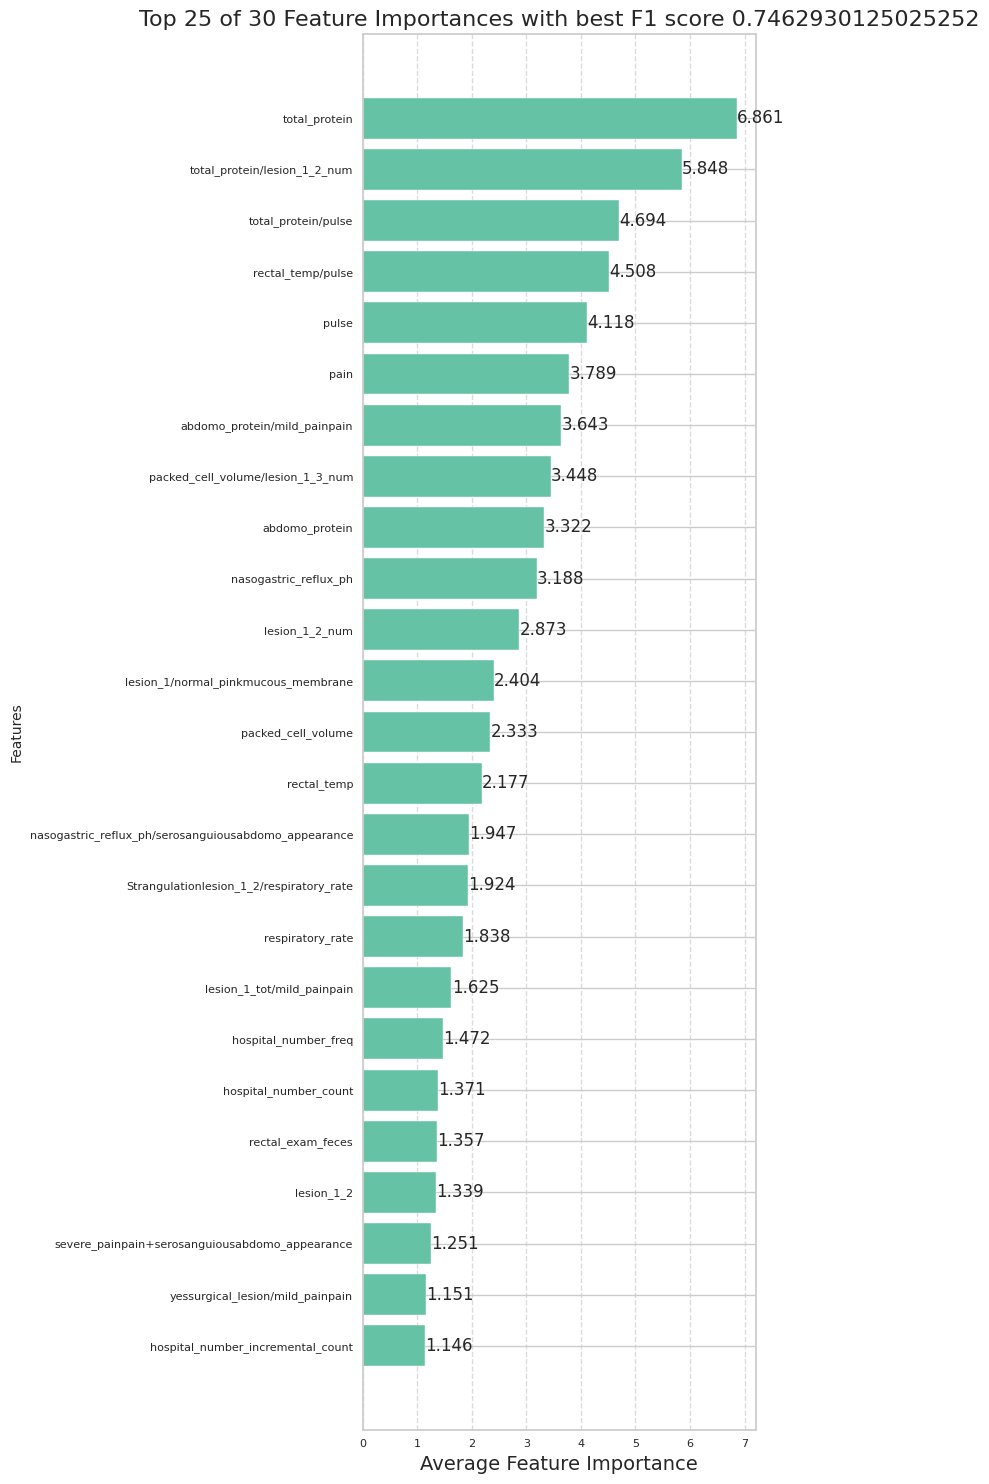

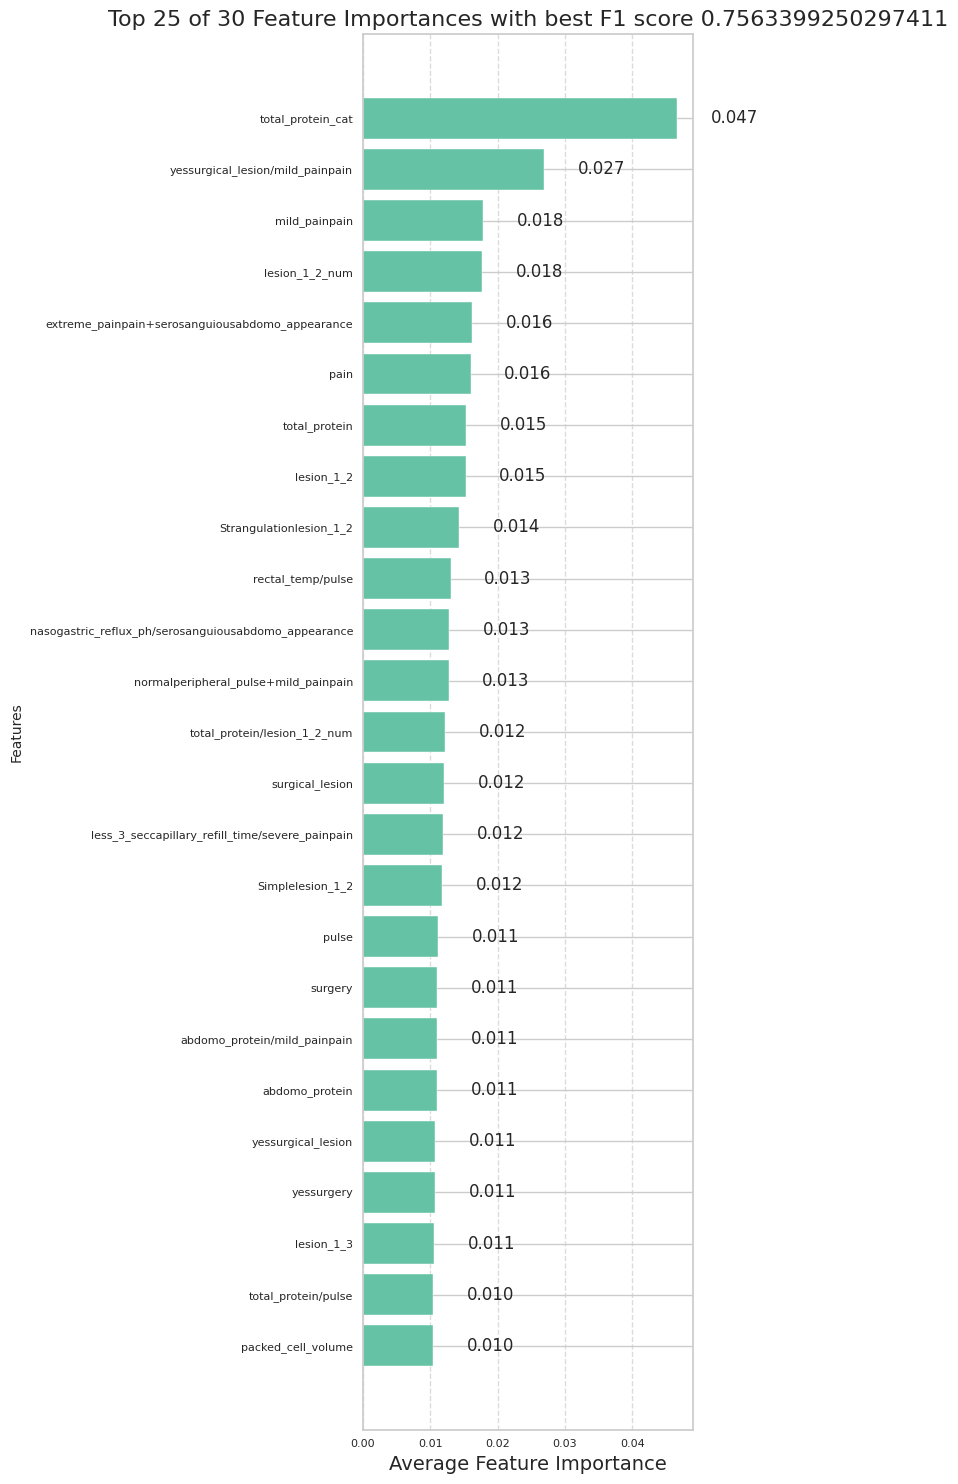

KeyboardInterrupt: 

In [16]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,30, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,30, 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,30, 'lgbm')

n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat)]
#n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

In [ ]:
y_train = y_train.map({0: 'died', 1: 'lived', 2: 'euthanized'})

classes = np.unique(y_train)  # Get unique class labels
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {target_map[cls]: weight for cls, weight in zip(classes, class_weights)}

print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

In [ ]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'merror',
            'objective': 'multi:softmax',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
            
        xgb_params2=xgb_params.copy() 
        xgb_params2['subsample']= 0.3
        xgb_params2['max_depth']=8
        xgb_params2['learning_rate']=0.005
        xgb_params2['colsample_bytree']=0.9

        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        lgb_params3=lgb_params.copy()  
        lgb_params3['subsample']=0.9
        lgb_params3['reg_lambda']=0.3461495211744402
        lgb_params3['reg_alpha']=0.3095626288582237
        lgb_params3['max_depth']=9
        lgb_params3['learning_rate']=0.007
        lgb_params3['colsample_bytree']=0.5

                
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.05,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'TotalF1',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'
        
        cb_params2=  cb_params.copy()
        cb_params2['learning_rate']=0.01
        cb_params2['depth']=8
        
        cb_params3={
            'iterations': self.n_estimators,
            'random_strength': 0.1, 
            'one_hot_max_size': 70, 'max_bin': 100, 
            'learning_rate': 0.008, 
            'l2_leaf_reg': 0.3, 
            'grow_policy': 'Depthwise', 
            'depth': 9, 
            'max_bin': 200,
            'od_wait': 65,
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'TotalF1',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        models = {
            'svc': SVC(gamma="auto", probability=True, random_state=self.random_state),
            'xgb': xgb.XGBClassifier(**xgb_params),
            'xgb2': xgb.XGBClassifier(**xgb_params2),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'lgb2': lgb.LGBMClassifier(**lgb_params2),
            'lgb3': lgb.LGBMClassifier(**lgb_params3),
            'cat': CatBoostClassifier(**cb_params),
            "cat_sym": CatBoostClassifier(**cb_sym_params),
            "cat_loss": CatBoostClassifier(**cb_loss_params),
            'cat2': CatBoostClassifier(**cb_params2),
            'brf': BalancedRandomForestClassifier(n_estimators=4000, n_jobs=-1, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
            'hist_gbm' : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80,
                                                         max_depth=6,class_weight=class_weights_dict, random_state=self.random_state)
        }
        return models

In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=5000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-12, 2) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
        f1_micro_score = f1_score(y_true, weighted_pred_labels, average='micro')
        return f1_micro_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [ ]:
kfold = True
n_splits = 1 if not kfold else 5
random_state = 42
random_state_list = [42] 
n_estimators = 9999 
early_stopping_rounds = 200
verbose = False
device = 'cpu'
splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], 3))
ensemble_score = []
ensemble_f1_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}
    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name)  :
            model.fit(X_train_, encode(y_train_,target_map), eval_set=[(X_val, encode(y_val,target_map))], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, encode(y_train_,target_map))
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict_proba(X_test)
        y_val_pred = model.predict_proba(X_val)

        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        f1_micro_score = f1_score(encode(y_val,target_map), y_val_pred_labels, average='micro')
        
        score = log_loss(encode(y_val,target_map), y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] F1 Micro Score: {f1_micro_score:.5f}, Logloss: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(encode(y_val,target_map), oof_preds)
    
    score = log_loss(encode(y_val,target_map), y_val_pred)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    f1_micro_score = f1_score(encode(y_val,target_map), y_val_pred_labels, average='micro')
    
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ---------------> F1 Micro Score: {f1_micro_score:.5f}, Logloss: {score:.5f}')
    
    ensemble_score.append(score)
    ensemble_f1_score.append(f1_micro_score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))
    
    gc.collect()

In [ ]:
# Calculate the mean F1 Score score of the ensemble
mean_score = np.mean(ensemble_f1_score)
std_score = np.std(ensemble_f1_score)
print(f'Ensemble F1 score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['outcome'] =  decode(np.argmax(test_predss, axis=1),target_map)
submission.to_csv('2023_09_30_2.csv',index=False)
submission.head()